In [1]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import sys

In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
sys.path.append('/home/raffaele/Documents/dmproject/WaveGrad/')

In [4]:
sys.path

['/home/raffaele/Documents/dmproject/classification',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/home/raffaele/.local/lib/python3.9/site-packages',
 '/usr/lib/python3.9/site-packages',
 '/home/raffaele/.local/lib/python3.9/site-packages/IPython/extensions',
 '/home/raffaele/.ipython',
 '/home/raffaele/Documents/dmproject/WaveGrad/']

In [5]:
path = '~/Documents/dmproject/datasets/'

In [6]:
df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [7]:
df_discretized = df.copy()
df_test_discretized = df_test.copy()

In [8]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

In [9]:
#discretize the variable
variables = ['CustomerCountry', 'CustomerLabel' ]
df_discretized = discretize_data(df_discretized, variables)
df_test_discretized = discretize_data(df_test_discretized, variables)

In [10]:
df_discretized

,TotalItems,DistinctItems,MaxItems,Entropy,TotalSale,Frequency,CustomerCountry,MonthSale,WeekSale,MonthFrequency,WeekFrequency,Recency,MonthItems,WeekItems,MonthDistinctItems,WeekDistinctItems,EntropyMonth,EntropyWeek,CustomerLabel
0,594,179,250,7.392,375.37,210,33,37.537,8.730,21.000,4.884,41,59.400,13.814,19.400,4.605,1.437,1.540,0
1,304,36,148,5.107,125.22,42,33,11.384,2.722,3.818,0.913,23,27.636,6.609,3.818,0.913,1.719,1.719,2
2,768,71,224,6.080,221.98,82,27,22.198,5.414,8.200,2.000,52,76.800,18.732,8.200,2.000,2.127,2.206,0
3,354,98,95,6.447,426.26,145,33,47.362,10.930,16.111,3.718,73,39.333,9.077,15.667,3.692,1.929,2.270,0
4,96,11,96,3.459,23.65,11,33,2.956,0.763,1.375,0.355,101,12.000,3.097,1.375,0.355,1.000,0.310,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,270,24,146,4.547,53.98,26,13,4.907,1.200,2.364,0.578,29,24.545,6.000,2.364,0.578,0.964,0.964,1
3317,10,1,10,1.000,2.08,1,33,0.231,0.058,0.111,0.028,60,1.111,0.278,0.111,0.028,0.918,0.918,1
3318,151,39,79,5.194,108.81,48,33,9.892,2.418,4.364,1.067,33,13.727,3.356,4.273,1.044,0.961,0.961,2
3319,15,4,15,2.000,17.10,4,33,5.700,1.900,1.333,0.444,280,5.000,1.667,1.333,0.444,1.000,1.000,2


In [11]:
y = df_discretized['CustomerLabel']
X = df_discretized.drop(columns=['CustomerLabel'])

## Try my Neural Network

In [12]:
from wavegrad.utility import *
from wavegrad.network import Sequential
from wavegrad.layers import LayerDense
from wavegrad.activations import *
from wavegrad.losses import MAE, MSE
from wavegrad.optimizers import *
from wavegrad.regularizer import L2
from keras.utils import np_utils

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [13]:
# X_train = X_train.values
# X_test = X_test.values

In [ ]:
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)
# y_train = y_train.values.reshape(y_train.shape[0], 1)
# y_test = y_test.values.reshape(y_test.shape[0], 1)

In [14]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [15]:
# unskew the data
# rfm_log = df[['TotalSale', 'TotalItems', 'DistinctItems', 'MaxItems', 'Entropy', 'Frequency']].apply(np.log, axis = 1).round(3)
rfm_log = df[['TotalItems',
              'DistinctItems',
              'MaxItems',
              'Entropy',
              'Frequency',
              'MonthFrequency',
              'WeekFrequency',
              'Recency',
              'MonthItems',
              'WeekItems',
              'MonthDistinctItems',
              'WeekDistinctItems',
              'EntropyMonth',
              'EntropyWeek']].apply(np.log, axis = 1).round(3)
# df = df[['DistinctItems', 'MaxItems', 'Entropy', 'Frequency']]

In [16]:
rfm_test = df_test_discretized[['TotalItems',
              'DistinctItems',
              'MaxItems',
              'Entropy',
              'Frequency',
              'MonthFrequency',
              'WeekFrequency',
              'Recency',
              'MonthItems',
              'WeekItems',
              'MonthDistinctItems',
              'WeekDistinctItems',
              'EntropyMonth',
              'EntropyWeek']].apply(np.log, axis = 1).round(3)

In [17]:
from sklearn.preprocessing import StandardScaler

# scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_log)# transform into a dataframe
df_scaled = pd.DataFrame(df_scaled, index = rfm_log.index, columns = rfm_log.columns)

In [18]:
X_train = df_scaled.values
y_train = y.values

In [22]:
y_train = np_utils.to_categorical(y_train)

NameError: name 'np_utils' is not defined

In [23]:
print(X_train.shape)
print(y_train.shape)

(3321, 14)
(3321,)


In [24]:
# # Network
net = Sequential()
net.add(LayerDense(14, 10, relu))
net.add(LayerDense(10, 3, sigmoid))

reg = L2(l2=0.001)
optim = GD(net.layers, lr=0.001, momentum=0.6)
net.use(MSE)
net.fit(X_train, y_train, epochs=200, optimizer=optim, validation_split=0.2, regularizer=reg)

  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (665,) (665,3) 

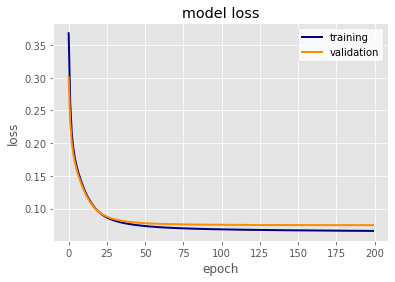

In [37]:
plot_loss(net)

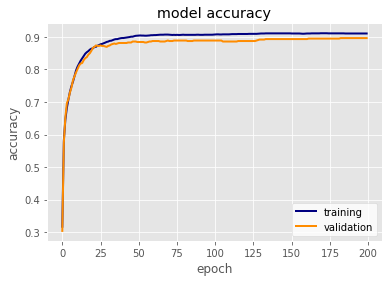

In [25]:
plot_accuracy(net)

In [26]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_test)# transform into a dataframe
df_scaled = pd.DataFrame(df_scaled, index = rfm_test.index, columns = rfm_test.columns)

In [27]:
y = df_test_discretized['CustomerLabel']

In [28]:
X_test = df_scaled.values

In [29]:
# y = test['customer_type']
# X = test.drop(columns=['customer_type','TotalItems','TotalSale'])

In [30]:
X_test = df_scaled.values
y_test = np_utils.to_categorical(y)

In [31]:
# Test set accuracy on test set.
out = net.predict(X_test)
accuracy(y_test, out)

0.8977135980746089

In [32]:
y_pred = []
for i in out:
    y_pred.append(np.argmax(i))

In [33]:
y_true = []

for i in y_test:
    y_true.append(np.argmax(i))

In [34]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

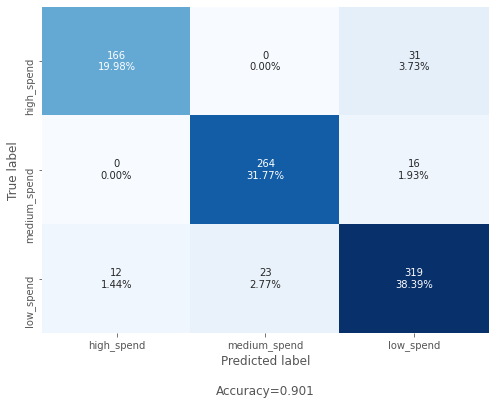

In [35]:
cf_matrix = confusion_matrix(y_pred, y_true)
labels = ['high_spend','medium_spend','low_spend']
cf_matrix
make_confusion_matrix(cf_matrix,categories=labels, figsize=(8,6), cbar=False)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       178
           1       0.94      0.92      0.93       287
           2       0.90      0.87      0.89       366

    accuracy                           0.90       831
   macro avg       0.90      0.91      0.90       831
weighted avg       0.90      0.90      0.90       831

